In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import nu, fu
from numpy import nan
from pandas import DataFrame, read_csv, read_excel, concat, get_dummies, isna
from re import split, search, sub, MULTILINE
from scipy.stats import f_oneway, ttest_ind, kruskal, norm
import itertools
import os.path as osp
import re
import statsmodels.api as sm

In [3]:

# load data frames
data_frames_dict = nu.load_data_frames(
    verbose=True, metrics_evaluation_open_world_scene_stats_df=''
)
scene_stats_df = data_frames_dict['metrics_evaluation_open_world_scene_stats_df'].copy()
print(sorted([cn for cn in scene_stats_df.columns if 'partici' in cn]))

No pickle exists for metrics_evaluation_open_world_scene_stats_df - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_scene_stats_df.csv.
['participant_id', 'participation_date']



## Stacked graph for triage errors

In [4]:

# load data frames
data_frames_dict = nu.load_data_frames(
    verbose=True, metrics_evaluation_open_world_csv_stats_df=''
)
csv_stats_df = data_frames_dict['metrics_evaluation_open_world_csv_stats_df'].copy()
print(sorted([cn for cn in csv_stats_df.columns if 'partici' in cn]))

No pickle exists for metrics_evaluation_open_world_csv_stats_df - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_csv_stats_df.csv.
['participant_id']


In [5]:

# Create the tag-to-SALT data frame
print("\nColumns to merge the scene stats dataset with the CSV stats on:")
on_columns = sorted(set(csv_stats_df.columns).intersection(set(scene_stats_df.columns)))
print(on_columns)


Columns to merge the scene stats dataset with the CSV stats on:
['participant_id', 'scene_id', 'session_uuid']


In [6]:

print('\nThe scene stats dataset columns we want to have in the merge:')
analysis_columns = sorted(set([
    'actual_engagement_distance', 'first_engagement', 'first_treatment', 'injury_correctly_treated_count', 'injury_not_treated_count',
    'injury_treatments_count', 'injury_wrongly_treated_count', 'last_engagement', 'last_still_engagement', 'measure_of_right_ordering',
    'patient_count', 'percent_hemorrhage_controlled', 'pulse_taken_count', 'stills_value', 'teleport_count',
    'time_to_hemorrhage_control_per_patient', 'time_to_last_hemorrhage_controlled', 'total_actions_count', 'triage_time',
    'voice_capture_count', 'walk_command_count', 'walk_value', 'walkers_value', 'wave_command_count', 'wave_value'
]).intersection(set(scene_stats_df.columns)))
print(analysis_columns)

# Merge the scene stats with the CSV stats
survey_columns = ['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'YrsMilExp']
columns_list = on_columns + analysis_columns + survey_columns
assert set(columns_list).issubset(set(scene_stats_df.columns)), "You've lost access to the analysis columns"
merge_df = csv_stats_df.merge(scene_stats_df[columns_list], on=on_columns, how='left').drop_duplicates()


The scene stats dataset columns we want to have in the merge:
['actual_engagement_distance', 'first_engagement', 'first_treatment', 'injury_correctly_treated_count', 'injury_not_treated_count', 'injury_wrongly_treated_count', 'last_engagement', 'last_still_engagement', 'measure_of_right_ordering', 'patient_count', 'percent_hemorrhage_controlled', 'pulse_taken_count', 'stills_value', 'teleport_count', 'time_to_hemorrhage_control_per_patient', 'time_to_last_hemorrhage_controlled', 'total_actions_count', 'triage_time', 'voice_capture_count', 'walk_command_count', 'walk_value', 'walkers_value', 'wave_command_count', 'wave_value']


In [7]:

# Get column and value descriptions dataset
file_path = osp.join(nu.data_folder, 'xlsx', 'Metrics_Evaluation_Dataset_organization_for_BBAI.xlsx')
dataset_organization_df = read_excel(file_path)

# Fix the doubled up descriptions
mask_series = dataset_organization_df.Labels.map(lambda x: ';' in str(x))
for row_index, label in dataset_organization_df[mask_series].Labels.items():
    labels_list = split(' *; *', str(label), 0)
    dataset_organization_df.loc[row_index, 'Labels'] = labels_list[0]
    
    # Append the new row to the DataFrame
    new_row = dataset_organization_df.loc[row_index].copy()
    new_row['Labels'] = labels_list[1]
    dataset_organization_df = concat([dataset_organization_df, new_row], ignore_index=True)

# Append the AD_Del_Omni_Text row to the DataFrame
mask_series = (dataset_organization_df.Variable == 'AD_Del_Omni')
new_row = dataset_organization_df.loc[mask_series].copy()
new_row['Variable'] = 'AD_Del_Omni_Text'
dataset_organization_df = concat([dataset_organization_df, new_row], ignore_index=True)

In [8]:

# Create the value description function
numeric_categories_mask_series = dataset_organization_df.Labels.map(lambda x: '=' in str(x))
value_descriptions_columns = dataset_organization_df[numeric_categories_mask_series].Variable.unique().tolist()
def get_value_description(column_name, column_value):
    """
    Get the description of a given value for a specific column.
    
    Parameters:
        column_name (str):
            The name of the column.
        column_value (Any):
            The value of the column.
    
    Returns:
        str: The description of the value.
    """
    value_description = ''
    
    # Check if the column value is not NaN
    if not isna(column_value):
        
        # Create a boolean mask to filter the dataset_organization_df
        mask_series = (dataset_organization_df.Variable == column_name) & ~dataset_organization_df.Labels.isnull()
        
        # Check if there are any matching rows
        if mask_series.any():
            
            # Filter the DataFrame using the mask
            df = dataset_organization_df[mask_series]
            
            # Create a new mask to find rows with labels matching the column value
            mask_series = df.Labels.map(lambda label: split(' *= *', str(label), 0)[0] == str(int(float(column_value))))
            
            # Check if there are any matching rows
            if mask_series.any():
                
                # Get the label for the matching row
                label = df[mask_series].Labels.squeeze()
                
                # Extract the description from the label
                value_description = split(' *= *', str(label), 0)[1]
    
    return value_description

In [9]:

# Add medical role back in
new_column = 'MedRole'
column_name = 'medical_role'
if new_column in scene_stats_df.columns:
    on_columns = sorted(set(merge_df.columns).intersection(set(scene_stats_df.columns)))
    columns_list = on_columns + [new_column]
    merge_df = merge_df.merge(
        scene_stats_df[columns_list], on=on_columns, how='left'
    ).rename(columns={new_column: column_name})
    merge_df[column_name] = merge_df[column_name].map(lambda cv: get_value_description('MedRole', cv)).replace('', nan)
print(merge_df.groupby(column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

                 record_count
medical_role                 
Other                   60484
Medical student         35742
EM faculty              23657
Paramedic               13196
EM resident             10888


In [10]:

tag_to_salt_df = fu.get_is_tag_correct_data_frame(merge_df, groupby_column='participant_id')

In [43]:

# Use the patients lists from the March 25th ITM BBAI Exploratory analysis email
desert_patients_list = [
    'Open World Marine 1 Female Root', 'Open World Marine 2 Male Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root'
]
jungle_patients_list = [
    'Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root'
]
submarine_patients_list = ['Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root']
urban_patients_list = ['Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Civilian 1 Female Root']
patients_list = desert_patients_list + jungle_patients_list + submarine_patients_list + urban_patients_list
assert set(patients_list).issubset(
    set(tag_to_salt_df.patient_id)
), f"tag_to_salt_df is missing these patients: {set(patients_list).difference(set(tag_to_salt_df.patient_id))}"
mask_series = tag_to_salt_df.patient_id.isin(patients_list)
tag_to_salt_df = tag_to_salt_df[mask_series]

In [44]:

# Add participant id back in
new_column = 'participant_id'
if (new_column in scene_stats_df.columns) and (new_column not in tag_to_salt_df.columns):
    on_columns = sorted(set(tag_to_salt_df.columns).intersection(set(scene_stats_df.columns)).intersection(set(['scene_id', 'session_uuid'])))
    print(on_columns)
    columns_list = on_columns + [new_column]
    tag_to_salt_df = tag_to_salt_df.merge(scene_stats_df[columns_list], on=on_columns)

In [45]:

import numpy as np

# Compute error_type, removing "Not Tagged" from consideration
def f(df):
    if df.last_tag in fu.error_table_df.index: error_type = fu.error_table_df[fu.error_table_df.index == df.last_tag][df.max_salt].squeeze()
    else: error_type = np.nan
    
    return error_type
groupby_columns = ['last_tag', 'max_salt', 'participant_id']
error_types_df = tag_to_salt_df.groupby(groupby_columns).patient_count.sum().to_frame().reset_index(drop=False)
error_types_df['error_type'] = error_types_df.apply(f, axis='columns')

# Convert the columns to the custom categorical type
error_types_df['last_tag'] = error_types_df['last_tag'].astype(fu.colors_category_order)
error_types_df['max_salt'] = error_types_df['max_salt'].astype(fu.salt_category_order)
error_types_df['error_type'] = error_types_df['error_type'].astype(fu.errors_category_order)

# Sort the DataFrame based on the custom categorical orders
error_types_df = error_types_df.sort_values(by=groupby_columns+['error_type'])

In [48]:

mask_series = (error_types_df.patient_count > 0)
error_types_df[mask_series].sort_values('patient_count', ascending=False).head()

,last_tag,max_salt,participant_id,patient_count,error_type
317,red,IMMEDIATE,2024206,4,Exact
319,red,IMMEDIATE,2024208,4,Exact
325,red,IMMEDIATE,2024215,4,Exact
332,red,IMMEDIATE,2024222,3,Exact
318,red,IMMEDIATE,2024207,3,Exact


In [49]:

# Get triage error rates
import re

rows_list = []
for participant_id, responder_categories_df in error_types_df.groupby('participant_id'):
    row_dict = {'participant_id': participant_id}
    df = responder_categories_df.groupby('error_type').patient_count.sum().reset_index(drop=False)
    total_patient_count = df.patient_count.sum()
    error_dict = df.set_index('error_type').patient_count.to_dict()

    over_patient_count = error_dict.get('Over', 0)
    over_triage_error_rate = 100*over_patient_count/total_patient_count
    row_dict['over_triage_error_rate'] = round(over_triage_error_rate, 1)

    under_patient_count = error_dict.get('Under', 0)
    under_triage_error_rate = 100*under_patient_count/total_patient_count
    row_dict['under_triage_error_rate'] = round(under_triage_error_rate, 1)

    critical_patient_count = error_dict.get('Critical', 0)
    critical_triage_error_rate = 100*critical_patient_count/total_patient_count
    row_dict['critical_triage_error_rate'] = round(critical_triage_error_rate, 1)
    
    rows_list.append(row_dict)
triage_error_rates_df = DataFrame(rows_list)

In [50]:

CATEGORY_DICT = {participant_id: participant_id for participant_id in triage_error_rates_df.participant_id}
CATEGORY_DICT.update({'Paramedic': 'EMT-Paramedic', 'EM Resident': 'EM-Resident'})

In [51]:

suffixing_fn = lambda x: f'{x}-triage Error' if (x in ['Over', 'Under']) else (f'{x} Error' if (x in ['Critical']) else x)
def show_stacked_horizontal_bar_chart(rates_df, ylabel=''):
    labels_list = [CATEGORY_DICT[c] for c in FILTERED_CATEGORIES_LIST][::-1]
    over_values, under_values, critical_values = [], [], []
    for column_value in FILTERED_CATEGORIES_LIST[::-1]:
        mask_series = (rates_df.participant_id == column_value)
        over_values.append(rates_df[mask_series].over_triage_error_rate.squeeze())
        under_values.append(rates_df[mask_series].under_triage_error_rate.squeeze())
        critical_values.append(rates_df[mask_series].critical_triage_error_rate.squeeze())
    
    # Create a horizontal bar chart for the first set of values
    over_bar = plt.barh(labels_list, over_values, color='#000000', label=suffixing_fn('Over'))
    
    # Create a stacked horizontal bar chart for the second set of values
    under_bar = plt.barh(labels_list, under_values, color='#717171', label=suffixing_fn('Under'), left=over_values)
    
    # Create a stacked horizontal bar chart for the third set of values
    # The data labels for critical errors should be in white (for better contrast)
    critical_bar = plt.barh(
        labels_list, critical_values, color='#bb0000', label=suffixing_fn('Critical'),
        left=[v1 + v2 for v1, v2 in zip(over_values, under_values)]
    )
    
    # Annotate the values of each value set inside their respective rectangles
    for bars, values in zip([over_bar, under_bar, critical_bar], [over_values, under_values, critical_values]):
        for bar, value in zip(bars, values):
            if (value >= 1): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center',
                color='white', fontsize=6
            )
            elif (value > 0): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height() + 0.06, f'{value:.01f}%', va='center', ha='center',
                color='black', fontsize=6
            )
    
    # Set the title, labels, legend, and grid
    plt.title('Triage Errors')
    plt.xlabel('Percent (%)')
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1.4, 0.62), loc='center right')
    plt.grid(False)
    
    # Display the chart
    plt.show()

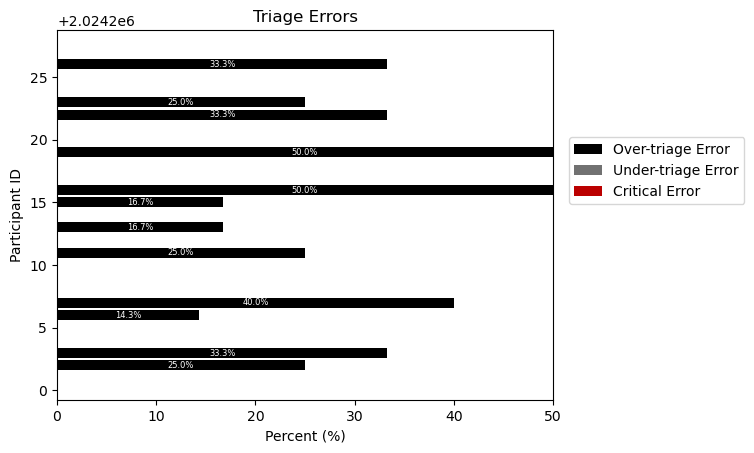

In [52]:

import matplotlib.pyplot as plt

FILTERED_CATEGORIES_LIST = [i for i in range(2024201, 2024228) if i in triage_error_rates_df.participant_id.tolist()]
show_stacked_horizontal_bar_chart(triage_error_rates_df, ylabel='Participant ID')

In [62]:

columns_list = sorted([cn for cn in scene_stats_df.columns if any(map(
    lambda x: x in cn, ['Med']
))])
print(columns_list)

['MedExp', 'MedRole']


In [36]:

triage_error_rates_df.set_index('participant_id')

,over_triage_error_rate,under_triage_error_rate,critical_triage_error_rate
participant_id,,,
2024201,40.0,0.0,0.0
2024202,53.8,0.0,0.0
2024203,72.7,0.0,9.1
2024204,33.3,0.0,0.0
2024205,57.1,0.0,0.0
2024206,28.6,0.0,0.0
2024207,33.3,0.0,33.3
2024208,42.9,0.0,7.1
2024209,35.7,0.0,0.0


In [110]:

merge_df[columns_list].groupby('medical_role').mean().reset_index(drop=False)

,medical_role,AD_KDMA_Sim,AD_KDMA_Text,PropTrust,ST_KDMA_Sim,ST_KDMA_Text,YrsMilExp
0,EM faculty,0.447020,0.370612,4.044940,0.582252,0.394053,NaN
1,EM resident,0.500000,0.475000,3.333333,0.634266,0.267488,NaN
2,Medical student,0.454806,0.409232,3.590147,0.581138,0.343896,NaN
3,Other,0.384224,0.388596,3.753988,0.528638,0.393900,3.331706
4,Paramedic,0.360401,0.401679,4.283375,0.576586,0.416110,NaN


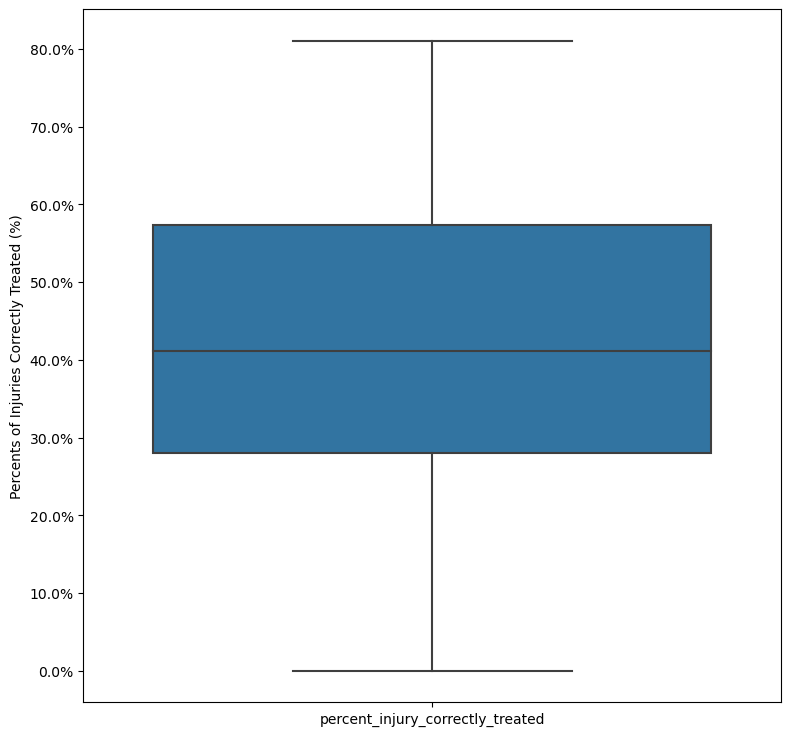

In [42]:

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.text import Text

# Create a figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Create a box plot of all the columns
columns_list = [
    'percent_injury_correctly_treated',
]
sns.boxplot(scene_stats_df[columns_list], ax=ax)

# Label the y-axis
ax.set_ylabel('Percents of Injuries Correctly Treated (%)')

# Humanize y tick labels
ax.set_yticklabels([
    Text(0, -10.0, '-10.0%'), Text(0, 0.0, '0.0%'), Text(0, 10.0, '10.0%'), Text(0, 20.0, '20.0%'), Text(0, 30.0, '30.0%'),
    Text(0, 40.0, '40.0%'), Text(0, 50.0, '50.0%'), Text(0, 60.0, '60.0%'), Text(0, 70.0, '70.0%'), Text(0, 80.0, '80.0%'),
    Text(0, 90.0, '90.0%')
])

plt.show()

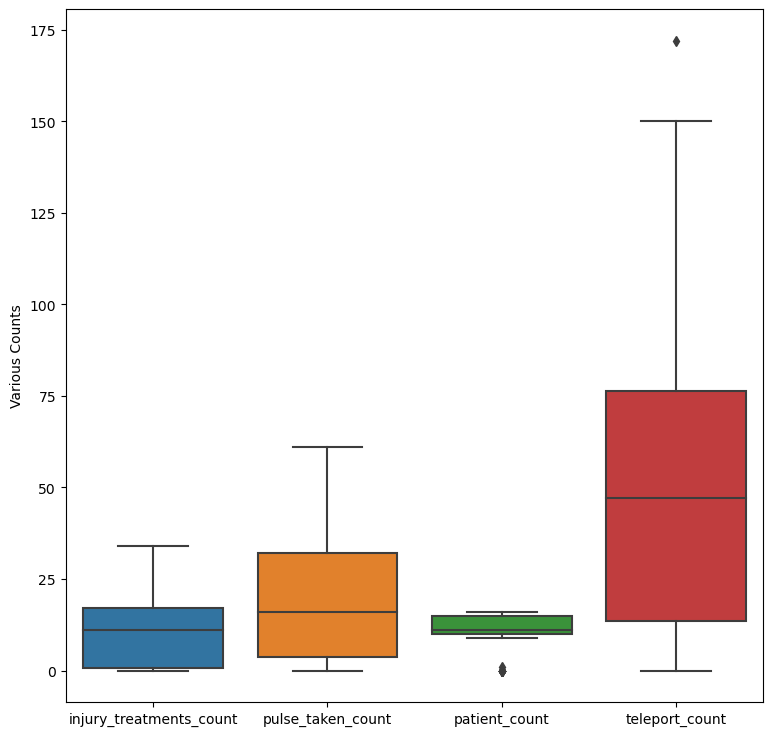

In [43]:

# Create a figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Create a box plot of all the columns
columns_list = [
    'injury_treatments_count',
    'pulse_taken_count',
    'patient_count',
    'teleport_count',
]
sns.boxplot(scene_stats_df[columns_list], ax=ax)

# Label the y-axis
ax.set_ylabel('Various Counts')

plt.show()

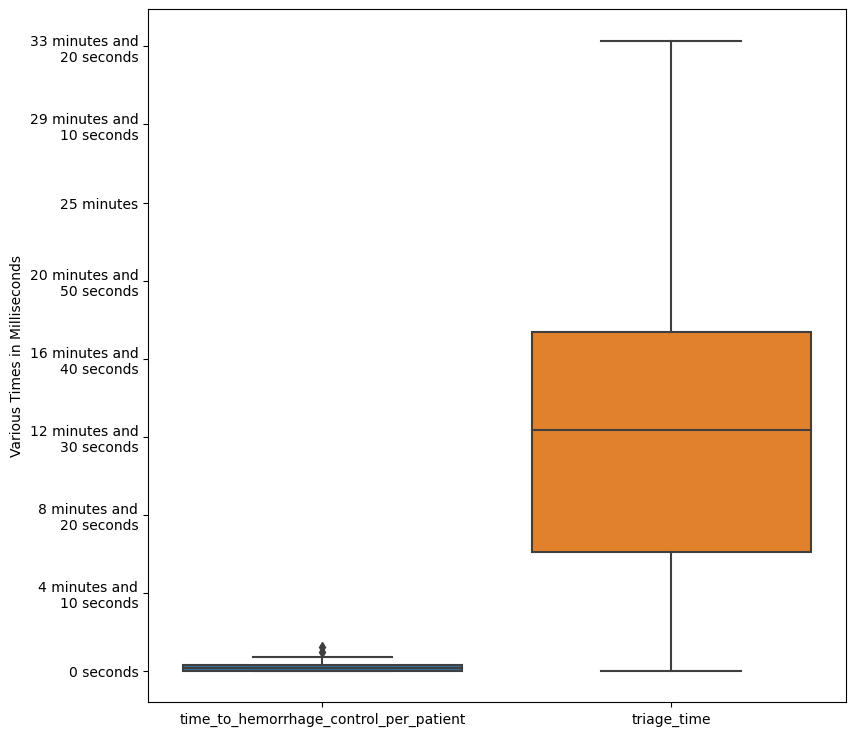

In [47]:

import humanize
from datetime import timedelta

# Create a figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Create a box plot of all the columns
columns_list = [
    'time_to_hemorrhage_control_per_patient',
    'triage_time',
]
sns.boxplot(scene_stats_df[columns_list], ax=ax)

# Label the y-axis
ax.set_ylabel('Various Times in Milliseconds')

# Humanize y tick labels
ax.set_yticklabels([
    Text(0, -250000.0, '4 minutes and\n10 seconds'), Text(0, 0.0, '0 seconds'), Text(0, 250000.0, '4 minutes and\n10 seconds'),
    Text(0, 500000.0, '8 minutes and\n20 seconds'), Text(0, 750000.0, '12 minutes and\n30 seconds'),
    Text(0, 1000000.0, '16 minutes and\n40 seconds'), Text(0, 1250000.0, '20 minutes and\n50 seconds'), Text(0, 1500000.0, '25 minutes'),
    Text(0, 1750000.0, '29 minutes and\n10 seconds'), Text(0, 2000000.0, '33 minutes and\n20 seconds'),
    Text(0, 2250000.0, '37 minutes and\n30 seconds')
])

plt.show()

In [53]:

from datetime import date

today = date.today()
for fn in dir():
    if fn.endswith('_df'):
        nu.save_data_frames(**{f'{today.year}{today.month:02d}{today.day:02d}participant_id_{fn}': eval(fn)}, verbose=True)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240516participant_id_csv_stats_df.csv
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240516participant_id_dataset_organization_df.csv
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240516participant_id_error_types_df.csv
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240516participant_id_merge_df.csv
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240516participant_id_responder_categories_df.csv
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240516participant_id_scene_stats_df.csv
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240516participant_id_tag_to_salt_df.csv
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240516particip

In [113]:

columns_list = ['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'YrsMilExp', 'medical_role']
df = merge_df[columns_list].groupby('medical_role').mean()
df = df.rename(columns={cn: 'mean_'+cn for cn in df.columns}).reset_index(drop=False)
df.medical_role = df.medical_role.map({
    'EM faculty': 'EM Faculty', 'EM resident': 'EM Resident', 'Medical student': 'Medical Student',
    'Other': 'Other', 'Paramedic': 'Paramedic'
})
on_columns = sorted(set(triage_error_rates_df.columns).intersection(set(df.columns)))
print(on_columns)
triage_error_rates_df.merge(df, on=on_columns).T

['medical_role']


,0,1,2,3,4
medical_role,EM Faculty,EM Resident,Medical Student,Other,Paramedic
over_triage_error_rate,35.7,50.0,41.0,41.2,42.1
under_triage_error_rate,0.0,0.0,0.0,0.0,0.0
critical_triage_error_rate,25.0,0.0,11.5,6.7,10.5
mean_AD_KDMA_Sim,0.44702,0.5,0.454806,0.384224,0.360401
mean_AD_KDMA_Text,0.370612,0.475,0.409232,0.388596,0.401679
mean_PropTrust,4.04494,3.333333,3.590147,3.753988,4.283375
mean_ST_KDMA_Sim,0.582252,0.634266,0.581138,0.528638,0.576586
mean_ST_KDMA_Text,0.394053,0.267488,0.343896,0.3939,0.41611
mean_YrsMilExp,NaN,NaN,NaN,3.331706,NaN


In [ ]:

# Search for teleports and get the euclidean distance to the nearest patient

In [15]:

mask_series = (csv_stats_df.injury_required_procedure == 'none')
';'.join(csv_stats_df[mask_series].csv_file_name.unique().tolist())

'02d472ac-f6fe-474c-815d-6125fadfcbf7_2024211.csv;04f80090-9e61-431d-8473-dccb75fed04d_2024207.csv;05e0be07-479a-4ea4-9b90-3fc7b79ef7ff_2024225.csv;0bc62b93-ac4d-40ef-bdfe-1d7badb24f70_2024208.csv;0e8693a1-1926-4d56-b0c4-ee2dc8181fc6_2024226.csv;1995e7ef-ef02-4fc1-b1ab-f137dbf69d48_2024217.csv;21f8cb5d-f5ac-4a01-9287-43df5f6751a1_2024219.csv;220b609b-0e35-454e-9afd-c84cbfa3e3ad_2024202.csv;23081f6e-875e-44f5-8bd0-edc3905f5c2c_2024201.csv;287389c4-4c48-4483-87c0-6b363b57bde2_2024220.csv;37a554ee-fc49-4730-819c-2d97727bb0b7_2024218.csv;385032e9-9801-4dcf-a841-b3703a0d9acd_2024209.csv;3cf14e31-f416-4c78-8a69-91bf0c685448_2024215.csv;45365e18-6e38-48e7-b4a2-6b448b209034_2024218.csv;499179ba-3138-4bae-918e-ffc7fb943760_2024206.csv;4bc46c8c-66e7-463d-b3a1-2a8303af4fd1_2024203.csv;50b15e40-9860-4574-8ab8-0bd960fe27de_2024220.csv;5a909dc4-0f86-430d-a400-e37139cba69f_2024212.csv;5d8d73a3-1898-4f64-8676-73edd1b7daa0_2024211.csv;67dc0230-511d-41ac-ae9b-850900ab9e6a_2024208.csv;6db9446c-2cd4-41b4-

In [7]:

# load data frames
data_frames_dict = nu.load_data_frames(
    verbose=True, metrics_evaluation_open_world_anova_df=''
)
anova_df = data_frames_dict['metrics_evaluation_open_world_anova_df'].copy()
print(sorted([cn for cn in anova_df.columns if 'trust' in cn.lower()]))

No pickle exists for metrics_evaluation_open_world_anova_df - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_anova_df.csv.
['mean_PropTrust']


In [8]:

anova_df.mean_PropTrust.unique().tolist()

[3.666666667, 4.333333333, 4.0, 3.333333333, 2.333333333, 0.0]

In [4]:

def entitle_column_name(column_name):
    """
    Entitles a column name based on specified rules.
    
    Parameters:
        column_name (str):
            The name of the column to be entitled.
    
    Returns:
        str
            The entitled column name.
    
    Notes:
        - If the column name starts with 'mean_' and the substring after 'mean_' exists in the value_description_dict,
          the entitled name is obtained from the corresponding value in the dictionary, prepended with 'Average ' if necessary.
        - Otherwise, the column name is split into parts, and each part is processed to ensure proper capitalization and word replacements.
    """
    
    # Check if the column name starts with 'mean_' and is present in the value_description_dict
    if column_name.startswith('mean_') and (column_name[5:] in value_description_dict):
        entitled_name = value_description_dict[column_name[5:]]
        
        # Prepend 'Average ' if the entitled name does not already start with it
        if not entitled_name.startswith('Average '):
            entitled_name = 'Average ' + entitled_name
    else:
        new_parts_list = []
        old_parts_list = [op for op in split('_', column_name, 0) if op]  # Split the column name by underscores
        for name_part in old_parts_list:
            
            # Check if the part contains a capital letter followed by lowercase letters (camelCase)
            if search('[A-Z][a-z]+', name_part):
                humps_list = [hp for hp in split('([A-Z][a-z]+)', name_part, 0) if hp]  # Split camelCase parts
                for i, hump_part in enumerate(humps_list):
                    
                    # Capitalize each part if it is all lowercase
                    if hump_part == hump_part.lower():
                        humps_list[i] = hump_part.title()
                    
                    # Replace specific abbreviations with full words
                    elif hump_part == 'Sim':
                        humps_list[i] = 'Simulation'
                    elif hump_part == 'Yrs':
                        humps_list[i] = 'Years of'
                    elif hump_part == 'Mil':
                        humps_list[i] = 'Military'
                    elif hump_part == 'Exp':
                        humps_list[i] = 'Experience'
                new_parts_list.extend(humps_list)
            else:
                
                # Process parts that are not in camelCase
                if name_part == name_part.lower():
                    
                    # Capitalize if the part is all lowercase and meets certain conditions
                    if (len(name_part) > 2) and (name_part != 'uuid'):
                        name_part = name_part.title()
                    
                    # Convert certain parts to uppercase
                    elif name_part not in ['to', 'of', 'per']:
                        name_part = name_part.upper()
                new_parts_list.append(name_part)
        
        # Replace 'Mean' with 'Average' if it is the first part
        if new_parts_list[0] == 'Mean':
            new_parts_list[0] = 'Average'
        entitled_name = ' '.join(new_parts_list)
    
    return entitled_name

In [5]:

print("\nGet column and value descriptions")
file_path = osp.join(nu.data_folder, 'xlsx', 'Metrics_Evaluation_Dataset_organization_for_BBAI.xlsx')
dataset_organization_df = read_excel(file_path)

print("\nFix the doubled up descriptions")
mask_series = dataset_organization_df.Labels.map(lambda x: ';' in str(x))
for row_index, label in dataset_organization_df[mask_series].Labels.items():
    labels_list = split(' *; *', str(label), 0)
    dataset_organization_df.loc[row_index, 'Labels'] = labels_list[0]
    
    # Append the new row to the DataFrame
    new_row = dataset_organization_df.loc[row_index].copy()
    new_row['Labels'] = labels_list[1]
    dataset_organization_df = concat([dataset_organization_df, new_row], ignore_index=True)

# Append the AD_Del_Omni_Text row to the DataFrame
mask_series = (dataset_organization_df.Variable == 'AD_Del_Omni')
new_row = dataset_organization_df.loc[mask_series].copy()
new_row['Variable'] = 'AD_Del_Omni_Text'
dataset_organization_df = concat([dataset_organization_df, new_row], ignore_index=True)

print("\nGet the column value descriptions")
mask_series = ~dataset_organization_df.Description.isnull()
df = dataset_organization_df[mask_series]
value_description_dict = df.set_index('Variable').Description.to_dict()
new_description_dict = value_description_dict.copy()
for k, v in value_description_dict.items():
    new_description_dict[k] = v
    if (not k.endswith('_Text')):
        new_key_name = f'{k}_Text'
        new_description_dict[new_key_name] = new_description_dict.get(new_key_name, v)
value_description_dict = new_description_dict.copy()


Get column and value descriptions

Fix the doubled up descriptions

Get the column value descriptions


In [5]:

groupby_columns = ['participant_id', 'session_uuid', 'scene_id']
rows_list = []
for (participant_id, session_uuid, scene_id), scene_df in scene_stats_df.groupby(groupby_columns):
    row_dict = {}
    for cn in groupby_columns: row_dict[cn] = eval(cn)
    for cn in scene_df.columns:
        if 'injur' in cn:
            row_dict[cn] = scene_df[cn].squeeze()
    rows_list.append(row_dict)
injury_counts_df = DataFrame(rows_list)

In [6]:

columns_list = [cn for cn in injury_counts_df.columns if 'injur' in cn]
injury_counts_df[columns_list]

,all_patient_injuries_count,injury_correctly_treated_count,injury_not_treated_count,injury_wrongly_treated_count
0,31,15,10,6
1,18,0,18,0
2,0,0,0,0
3,0,0,0,0
4,23,11,8,4
...,...,...,...,...
63,19,5,9,5
64,23,12,7,4
65,31,23,2,6
66,31,10,20,1


In [11]:

assert (
    scene_stats_df.all_patient_injuries_count == scene_stats_df[
        ['injury_correctly_treated_count', 'injury_not_treated_count', 'injury_wrongly_treated_count']
    ].sum(axis='columns')
).all(), "The sum of the various injury counts does not match the total injury count for all rows."

In [8]:

df = injury_counts_df.sample(5)
print(f"""
        # Create a mock DataFrame with all injury columns
        self.injury_counts_df = DataFrame({{
            "all_patient_injuries_count": {df.all_patient_injuries_count.tolist()}
            "injury_correctly_treated_count": {df.injury_correctly_treated_count.tolist()}
            "injury_not_treated_count": {df.injury_not_treated_count.tolist()}
            "injury_wrongly_treated_count": {df.injury_wrongly_treated_count.tolist()}
        }})""")


        # Create a mock DataFrame with all injury columns
        self.injury_counts_df = DataFrame({
            "all_patient_injuries_count": [20, 32, 25, 0, 18]
            "injury_correctly_treated_count": [3, 19, 9, 0, 0]
            "injury_not_treated_count": [13, 11, 11, 0, 18]
            "injury_wrongly_treated_count": [4, 2, 5, 0, 0]
        })


In [22]:

groupby_columns = ['participant_id', 'session_uuid', 'scene_id']
millisecond_threshold = 0
for (participant_id, session_uuid, scene_id), scene_df in csv_stats_df.groupby(groupby_columns):
    
    # Loop through each injury and make a determination if it's treated or not
    injury_correctly_treated_count = 0
    for patient_id, patient_df in scene_df.groupby('patient_id'):
        for injury_id, injury_df in patient_df.groupby('injury_id'):
            is_correctly_treated = fu.get_is_injury_correctly_treated(injury_df, patient_df)
            if is_correctly_treated: injury_correctly_treated_count += 1

In [23]:

mask_series = (injury_df.action_type == 'INJURY_TREATED')
action_ticks_list = sorted(injury_df[mask_series].action_tick.unique())
mask_series = ~injury_df.injury_required_procedure.isnull()
required_procedure = injury_df[mask_series].injury_required_procedure.mode().squeeze()
print(required_procedure)
for action_tick in action_ticks_list:
    mask_series = patient_df.action_tick.map(
        lambda ts: abs(ts - action_tick) < millisecond_threshold
    ) & patient_df.action_type.isin(['TOOL_APPLIED'])
    if mask_series.any():
        print([(required_procedure == self.tool_type_to_required_procedure_dict.get(tool_type)) for tool_type in patient_df[mask_series].tool_applied_type])
        is_correctly_treated = any(
            [(required_procedure == self.tool_type_to_required_procedure_dict.get(tool_type)) for tool_type in patient_df[mask_series].tool_applied_type]
        )

Series([], dtype: object)


In [24]:

injury_df.dropna(axis='columns', how='all').T

,139341
action_type,INJURY_RECORD
action_tick,19200
event_time,2024-04-05 12:10:51
session_uuid,9f3bb117-3a4b-4bc7-9237-e2d9920d5333
csv_file_subpath,Human_Sim_Metrics_Data_4-12-2024/9f3bb117-3a4b...
injury_record_id,L Shoulder Broken
injury_record_patient_id,Patient X Root
injury_record_required_procedure,splint
injury_record_severity,medium
injury_record_body_region,leftArm


In [16]:

columns_list = ['action_type', 'action_tick']
patient_df[columns_list]

,action_type,action_tick
42381,PATIENT_ENGAGED,1262495
42407,BREATHING_CHECKED,1266435
42408,INJURY_TREATED,1267526
42409,TOOL_APPLIED,1267526
42420,INJURY_TREATED,1273515
42422,PULSE_TAKEN,1273567
42483,INJURY_TREATED,1281386
42485,PULSE_TAKEN,1281897
42508,INJURY_TREATED,1286988
42626,PATIENT_DEMOTED,192305


In [29]:

from pandas import Series

groupby_columns = ['participant_id', 'session_uuid', 'scene_id', 'patient_id']
for (participant_id, session_uuid, scene_id, patient_id), patient_df in csv_stats_df.groupby(groupby_columns):
    for injury_id, injury_df in patient_df.groupby('injury_id'):
        action_ticks_list = sorted(injury_df.action_tick.unique())
        mask_series = ~patient_df.tool_type.isnull() & patient_df.action_tick.isin(action_ticks_list)
        if mask_series.any():
            df = patient_df[mask_series]
            mask_series = ~injury_df.injury_record_required_procedure.isnull()
            required_procedure = injury_df[mask_series].injury_record_required_procedure.mode().squeeze()
            if isinstance(required_procedure, Series):
                required_procedure = '(who knows?)'
                raise
            for tool_type in df.tool_type:
                is_correctly_treated = (required_procedure == fu.tool_type_to_required_procedure_dict.get(tool_type))
                print(
                    f'{patient_id} has a {injury_id} which requires a {required_procedure} and it {"was" if is_correctly_treated else "was not"} correctly treated'
                )
                raise

Adept Shooter Root has a R Bicep Puncture which requires a tourniquet and it was correctly treated


RuntimeError: No active exception to reraise

In [30]:

columns_list = [cn for cn in injury_df.columns if 'required_procedure' in cn]
injury_df[columns_list]

,injury_record_required_procedure,injury_treated_required_procedure,injury_required_procedure
42658,tourniquet,NaN,tourniquet
44199,NaN,tourniquet,tourniquet


In [54]:

osp.basename(osp.join('../data/logs', df.csv_file_subpath.squeeze()))

'04f80090-9e61-431d-8473-dccb75fed04d_2024207.csv'